# CogPonder: An Interoperable Model of Response Times in Cognitive Tasks

We are interested in a model of response time that is interoperable in human data and computational agents.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrates CogPonder, a differentiable model that produces human-like speed-accuracy in decision making tasks.

The model iterates over a recurrent decision network, terminating only when it reaches a halting step. The network is trained to 1) maximize decision accuracy and 2) maximize the similarity between the human response time distribution and the halting steps of the network.


## Tasks

### N-back Task

N-back is a cognitive test commonly used to tap into working memory. In this task, human subjects are presented with a sequence of symbols, and are asked to respond with the "target" button whe the current symbol matches the one from N steps earlier in the sequence. The load factor N can be adjusted the difficulty of the task.

Here, we use a 2-back dataset from [Self-Regulation Ontology study]() to evaluate the architecture. The mock dataset includes, for each subject, trial-level $X$ (symbol), $is_targets$ (or $y$; whether it was a target), $responses$, and $response\_times$.


The dataset interface provides the following features:

- $X_i$: previous 3 symbols for the trial i; $X_i$ is a 3-dimensional vector of integers.
- $trial\_type$: see the "Trial types" section below.
- $is\_targets_i$: whether the trial i is a match; $is\_targets_i$ is a boolean.
- $responses_i$: the response of the subject for the trial i; $responses_i$ is a boolean.
- $response\_steps_i$: the response step of the subject for the trial i; $response\_times_i$ is a float. Response steps represent RT in 50ms steps.

#### Trial types

The  dataset includes 3 trial types depending on the response and whether the symbols was a target:

1. correct match
2. correct non-match
3. incorrect match
4. incorrect non-match


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:
$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. The duration of each step is in fact a hyperparameter of the model, but for brevity is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution), and $p_n$ is the probability of halting at step $n$, which imply that in all the previous steps it did not halt. The halting probability is a function of the latent state $h_n$, $lambda_n$, and the current symbol $X$.

For the N-back task, we define X as a moving window of recent N+1 symbols, e.g., [A, B, C] and [B, C, D], ...; and $y$ is either NON_MATCH (False or 0) or MATCH (True or 1).

### Output

The *CogPonder* network produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch. Batch items are the trials in the N-back task.


### Criterion

$L = L_{rec} + L_{reg_{RT}}$


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from cogponder import CogPonderNet, ICOM
from cogponder.datasets import NBackMockDataset, NBackDataModule, NBackSRODataset

# CONSTANTS


In [2]:

# load the data
# mock_data = NBackMockDataset(n_subjects=1, n_trials=198, n_stimuli=5, n_back=2)
data = NBackSRODataset(n_subjects=1, n_back=2)  # shape (n_subjects, (...))

# create data module for handling data in PyTorch Lightning
datamodule = NBackDataModule(data, batch_size=8)

n_symbols = torch.unique(data[0][0]).shape[0]
max_response_step = data[0][4].max() + 10
lambda_p = 1. / data[0][4].median()

max_response_step = max_response_step.item()
lambda_p = lambda_p.item()
n_symbols

5

In [3]:
import torch.nn.functional as F


In [6]:

# define the underlying decision model
import cogponder


decision_model = ICOM(n_inputs=n_symbols+1, n_channels=n_symbols, n_outputs=2)

# the pondering model
model = CogPonderNet(
    decision_model,
    embeddings_dim=n_symbols,
    max_response_steps=max_response_step,
    lambda_p= lambda_p,
    loss_beta=.2,
    example_input_array=data[0][0][:2],
    loss_by_trial_type=False,)

logger = TensorBoardLogger('', log_graph=False)


# y_steps, p_halts, h = model(data[0][0][:3])
# from cogponder.loss import ReconstructionLoss, RegularizationLoss
# from torch import nn
# loss_rec_fn = ReconstructionLoss(nn.BCELoss(reduction='mean'))
# loss_rec_fn(p_halts, y_steps, data[0][2][:3])

# # define the training parameters
trainer = pl.Trainer(
    logger=logger,
    max_epochs=-1,
    log_every_n_steps=8,
    auto_scale_batch_size=True,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.01),
    ])

# train the model on the dataset
trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name           ┃ Type       ┃ Params ┃            In sizes ┃           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ decision_model │ ICOM       │    100 │ [[2, 3], [1, 2, 5]] │ [[2, 2], [1, 2, 5]] │
│ 1 │ halt_node      │ Sequential │      7 │           [1, 2, 6] │           [1, 2, 1] │
└───┴────────────────┴────────────┴────────┴─────────────────────┴─────────────────────┘

Trainable params: 107                                                                                              
Non-trainable params: 0                                                                                            
Total params: 107                                                                                                  
Total estimated model params size (MB): 0

Output()

In [7]:
# DEBUG

import torch

X_train, _, _, _, rt_train = datamodule.dataset[datamodule.train_dataset.indices]
X_test, _, _, _, rt_test = datamodule.dataset[datamodule.test_dataset.indices]

with torch.no_grad():
    model.eval()
    rt_train_pred = model(X_train)[2].detach()
    rt_test_pred = model(X_test)[2].detach()

    # DEBUG report the ground truth and predicted response times
    print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()


TRUE TRAIN: [9, 8, 10, 14, 13, 10, 8, 9, 11, 10, 11, 8, 10, 8, 9, 9, 5, 5, 7, 7, 6, 6, 6, 6, 7, 12, 15, 14, 10, 11, 9, 8, 12, 12, 12, 10, 7, 9, 13, 14, 12, 8, 5, 5, 6, 10, 11, 10, 10, 8, 8, 14, 9, 10, 7, 7, 6, 5, 6, 6, 10, 8, 10, 8, 10, 6, 7, 7, 10, 10, 8, 8, 7, 6, 7, 11, 10, 15, 9, 5, 5, 5, 5, 7, 8, 14, 10, 6, 7, 5, 9, 9, 12, 10, 11, 14, 6, 8, 10, 9, 15, 6, 6, 8, 14, 12, 13, 9, 8, 8, 7, 14, 13, 8, 7, 10, 12, 8, 8, 9, 10, 5, 7, 8, 7, 6, 11, 6, 10, 9, 8, 5, 9, 7, 8, 10, 8, 11, 8, 8, 7, 8, 6, 10, 7, 5, 8, 9, 8, 7, 10, 9, 7, 4, 8, 9] 
PRED TRAIN: [1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 3, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 5, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 3, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1,

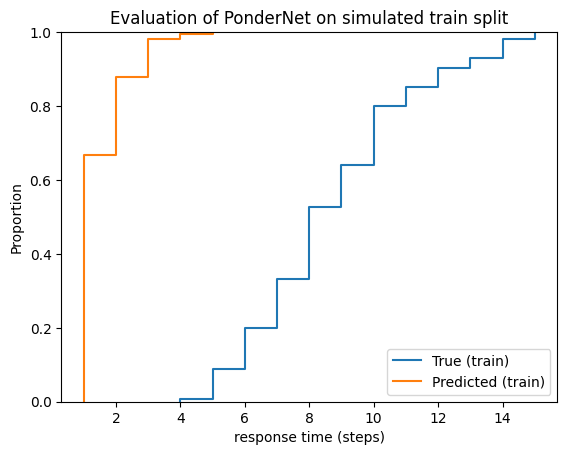

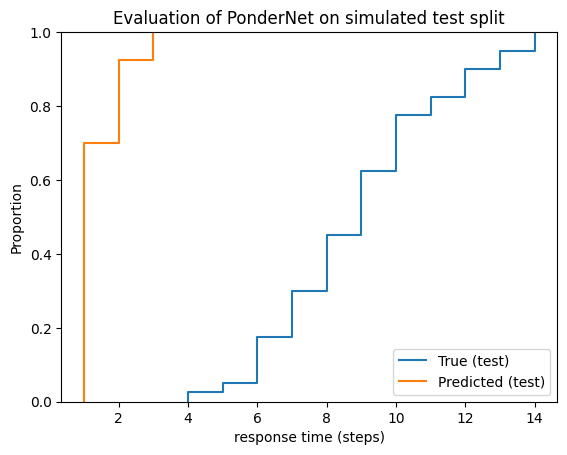

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted (train)')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted (test)')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

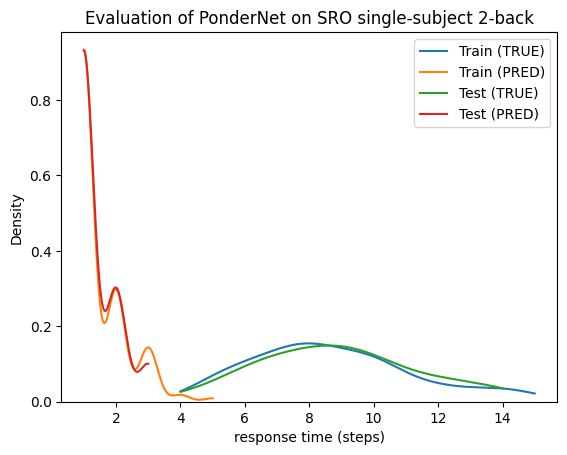

In [9]:

sns.kdeplot(rt_train.detach(), label='Train (TRUE)', cut=0)
sns.kdeplot(rt_train_pred.detach(), label='Train (PRED)', cut=0)

sns.kdeplot(rt_test.detach(), label='Test (TRUE)', cut=0)
sns.kdeplot(rt_test_pred.detach(), label='Test (PRED)', cut=0)


plt.title('Evaluation of PonderNet on SRO single-subject 2-back')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()